This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ... Or you can make the input file name(s) anything you want.

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the RATIO OF BADS TO GOODS retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. I think in general it's better to keep balance = 0.

The filter is pretty fast. The wrapper is what takes the most time. The two most important paramenters are the number of variables you want to save from the filter (num_filter) and the number you want from the wrapper (num_wrapper). 

There's a parameter njobs that controls the # threads used in the wrapper. Set it to 1 for a single thread and it should work fine, but you might be able to succeed with njobs = -1, which lets the machine set the maximum # threads based on the CPU. With this setting the kernel may die because of memory. The njobs = -1 doesn't take into consideration the memory requirements.

Recommendations: Try a few simple runs just to make sure all's working. Start with num_filter = 20, num_wrapper = 5, increase from there. I like num_filter as high as around 10 to 20% of the # candidate variables, but not much higher than a few hundred. You don't need num_wrapper large if you're doing forward selection. Most problems will saturate before 20. You can try a few different simple wrapper models like RF (5 trees, 10 layers), catboost (10 trees, 3 layers), LGBM (same). They're pretty fast. You can try forward and backward. I'd start with forward. In the end, select one of these as your favorite run and go with those variables. Don't mix variables across different runs.

I find forward selection runs much faster than backward.

Make sure your validation/out-of-time population and any other record exclusion is set correctly and as you want for your problem in cell 3.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1 # This is number of files you have for feature selection. Usually this will just be 1.

# This is the number of variables from the filter that you want the wrapper to consider.
# Make it as high as your machine and time can handle. 
# I recommend set num_filter to be at least about 10 to 20% of the original # variables. 
num_filter = 300

# I recommend set num_wrapper to be about 30, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper about twice this saturation number.
num_wrapper = 20

balance = 0 # a nonzero value will then be ratio of goods to bads.

# This is a cutpoint for measuring a detection rate. It's not that important to get it exact. 
# Set it around where you think the business cutoff is expected to be.
detect_rate = .03

index_name = 'record'  # set this string as whatever your record number field is called
y_name = 'fraud_label' # set this string to be whatever your binary label is called
good_label = 0  # you can make the goods or bads zero or 1. If you want high to be bad, then set bad=1, good=0.
bad_label = 1

# You need to explicitly set these record numbers in the next two lines. They define the range of records you want to use for feature selection.
# Frequently we want to ignore some early records (if not, set the ignore_records_below to 0)
# We may want to ignore some later records, for example an out-of-time data set.
ignore_records_above = 833508 # remove the last two months as the out-of-time data (OOT)
ignore_records_below = 38512 # remove the first 2 weeks of records since their variables aren't well formed

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'vars.csv' # if you only have one file for variables, set num_files=1 and put the name of the file here.
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
# you need to explicitly set these record numbers in the next two lines. They define the range of records you want to use for feature selection.
# frequently we want to ignore some early records (if not, set the )
    df = df[df.index <= ignore_records_above] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= ignore_records_below] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on vars.csv size is (1000000, 1841)


<timed exec>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'fraud_label' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
vars.csv                                            variable  filter score
0                                       fraud_label      1.000000
1730                    max_count_by_fulladdress_30      0.359856
1714                        max_count_by_address_30      0.358842
1729                     max_count_by_fulladdress_7      0.342985
1713                         max_count_by_address_7      0.342962
9                                 address_day_since      0.333766
37                            fulladdress_day_since      0.333201
15                                 address_count_30      0.332275
43                             fulladdress_count_30      0.331901
1728                     max_count_by_fulladdress_3      0.329478
1712                         max_count_by_address_3      0.329069
14                                 address_count_14      0.322060
42                             fulladdress_count_14 

In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [5]:
filter_score.head(30)

,variable,filter score
0,fraud_label,1.000000
1,max_count_by_fulladdress_30,0.359856
2,max_count_by_address_30,0.358842
3,max_count_by_fulladdress_7,0.342985
4,max_count_by_address_7,0.342962
5,address_day_since,0.333766
6,fulladdress_day_since,0.333201
7,address_count_30,0.332275
8,fulladdress_count_30,0.331901
9,max_count_by_fulladdress_3,0.329478


In [6]:
filter_score.tail(10)

,variable,filter score
1831,ssn_homephone_unique_count_for_address_0,0.000006
1832,ssn_zip5_unique_count_for_ssn_firstname_1,0.000005
1833,homephone_name_dob_unique_count_for_address_0,0.000005
1834,ssn_zip5_unique_count_for_ssn_lastname_3,0.000005
1835,ssn_dob_unique_count_for_ssn_firstname_0,0.000003
1836,homephone_name_dob_unique_count_for_zip5_0,0.000003
1837,ssn_zip5_unique_count_for_ssn_lastname_1,0.000003
1838,ssn_lastname_unique_count_for_name_0,0.000001
1839,fulladdress_dob_unique_count_for_name_0,0.000001
1840,fulladdress_unique_count_for_address_0,0.000000


In [7]:
filter_score.shape

(1841, 2)

In [8]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['max_count_by_fulladdress_30', 'max_count_by_address_30', 'max_count_by_fulladdress_7', 'max_count_by_address_7', 'address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'max_count_by_fulladdress_3', 'max_count_by_address_3', 'address_count_14', 'fulladdress_count_14', 'max_count_by_fulladdress_1', 'max_count_by_address_1', 'fulladdress_count_7', 'address_count_7', 'address_count_0_by_30', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_ssn_homephone_30', 'address_unique_count_for_homephone_name_dob_30', 'fulladdress_unique_count_for_homephone_name_dob_30', 'fulladdress_unique_count_for_dob_homephone_30', 'address_unique_count_for_ssn_homephone_30', 'address_unique_count_for_ssn_name_30', 'address_unique_count_for_ssn_name_fulladdress_30', 'address_unique_count_for_ssn_zip5_30', 'fulladdress_unique_count_for_ssn_name_30', 'fulladdress_unique_count_for_ssn_firstname_30', 'fulladdress_unique_count_for_ssn_lastname_30', 'fulladdr

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,max_count_by_fulladdress_30,max_count_by_address_30,max_count_by_fulladdress_7,max_count_by_address_7,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,max_count_by_fulladdress_3,max_count_by_address_3,...,max_count_by_name_dob_1,max_count_by_ssn_1,max_count_by_ssn_firstname_1,max_count_by_ssn_dob_1,max_count_by_ssn_lastname_1,max_count_by_ssn_name_1,max_count_by_ssn_name_dob_1,homephone_count_3,name_dob_count_0_by_14,homephone_count_7
record,,,,,,,,,,,,,,,,,,,,,
38512.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,3.0
38513.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,14.0,3.0
38514.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,1.0
38515.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,1.0
38516.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,1.0


In [10]:
df_keep.shape

(794997, 300)

In [11]:
Y.head()

,fraud_label
record,
38512.0,0.0
38513.0,0.0
38514.0,0.0
38515.0,0.0
38516.0,0.0


In [12]:
Y = Y.values.ravel()
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[0. 0. 0. ... 0. 0. 0.]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:05:39.758425


In [15]:
print(X.shape,Y.shape)

(794997, 300) (794997,)


In [16]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [17]:
def fdr(classifier, x, y, cutoff=0.03):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
        y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
    y_prob = y_prob.flatten()  # Ensure y_prob is 1D
    num_fraud = np.sum(y == 1)  # Count the total number of frauds

    # Sort the proba list from high to low while retaining the true (not predicted) fraud label
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

    # Return the FDR score (#fraud_in_cutoff / #total_fraud)
    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

## Run a wrapper on the remaining top variables

In [18]:
# This is a parallel running parameter. You can try it set to -1, but sometimes the data is too large to
# be divided into that many threads and the next cell quits. A safe value is 1 for no parallelization but it 
# the runs slower. You might experiment to see how big you can set this for your data on your machine.
njobs = -1

In [19]:
%%time
import warnings 
warnings.filterwarnings("ignore") 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=10,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for backward selection
sfs.fit(X,Y)

CPU times: user 13.7 s, sys: 9.99 s, total: 23.7 s
Wall time: 17min 44s


SequentialFeatureSelector(cv=2,
                          estimator=LGBMClassifier(n_estimators=10,
                                                   num_leaves=3),
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x69c3d5900>)

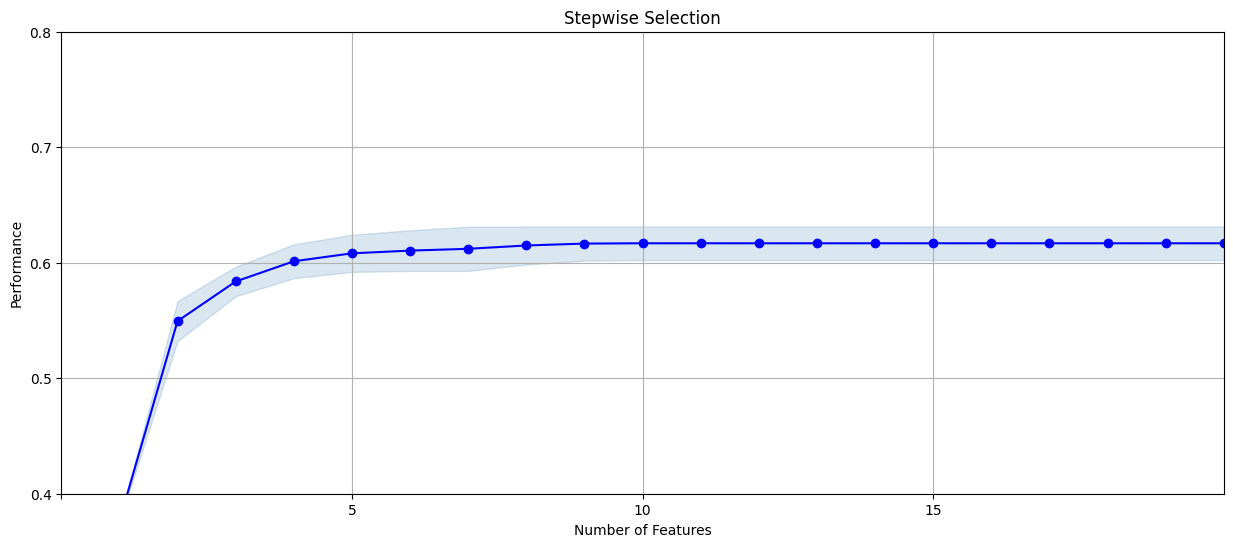

In [20]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, num_wrapper, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.4,.8])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [21]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [22]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [23]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(1,)","[0.37732892216611524, 0.37523942190492776]",0.376284,"(max_count_by_address_30,)",0.004495,0.001045,0.001045,1.0,max_count_by_address_30
2,"(1, 177)","[0.5321260665157583, 0.5667769458471182]",0.549452,"(max_count_by_address_30, max_count_by_ssn_dob_7)",0.074545,0.017325,0.017325,2.0,max_count_by_ssn_dob_7
3,"(1, 177, 299)","[0.5709559463694933, 0.5965523245690406]",0.583754,"(max_count_by_address_30, max_count_by_ssn_dob...",0.055066,0.012798,0.012798,3.0,homephone_count_7
4,"(1, 177, 217, 299)","[0.5866271983283998, 0.6158802019850252]",0.601254,"(max_count_by_address_30, max_count_by_ssn_dob...",0.062933,0.014627,0.014627,4.0,zip5_count_1
5,"(1, 177, 198, 217, 299)","[0.5920250740031342, 0.6242382030297754]",0.608132,"(max_count_by_address_30, max_count_by_ssn_dob...",0.069301,0.016107,0.016107,5.0,max_count_by_homephone_3
6,"(1, 7, 177, 198, 217, 299)","[0.5928956991119624, 0.6280689535086192]",0.610482,"(max_count_by_address_30, fulladdress_count_30...",0.075669,0.017587,0.017587,6.0,fulladdress_count_30
7,"(1, 2, 7, 177, 198, 217, 299)","[0.5928956991119624, 0.6312032039004005]",0.612049,"(max_count_by_address_30, max_count_by_fulladd...",0.082412,0.019154,0.019154,7.0,max_count_by_fulladdress_7
8,"(1, 2, 7, 177, 198, 217, 238, 299)","[0.5984676998084625, 0.6313773289221661]",0.614923,"(max_count_by_address_30, max_count_by_fulladd...",0.070799,0.016455,0.016455,8.0,max_count_by_homephone_30
9,"(1, 2, 5, 7, 177, 198, 217, 238, 299)","[0.6017760752220094, 0.6313773289221661]",0.616577,"(max_count_by_address_30, max_count_by_fulladd...",0.063682,0.014801,0.014801,9.0,fulladdress_day_since
10,"(1, 2, 5, 7, 177, 184, 198, 217, 238, 299)","[0.6022984502873063, 0.6313773289221661]",0.616838,"(max_count_by_address_30, max_count_by_fulladd...",0.062558,0.014539,0.014539,10.0,ssn_count_30


In [24]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [25]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1        max_count_by_address_30
2         max_count_by_ssn_dob_7
3              homephone_count_7
4                   zip5_count_1
5       max_count_by_homephone_3
6           fulladdress_count_30
7     max_count_by_fulladdress_7
8      max_count_by_homephone_30
9          fulladdress_day_since
10                  ssn_count_30
11        max_count_by_address_7
12             address_day_since
13              address_count_30
14        max_count_by_address_3
15              address_count_14
16          fulladdress_count_14
17        max_count_by_address_1
18           fulladdress_count_7
19               address_count_7
20         address_count_0_by_30
Name: variable name, dtype: object

In [26]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
max_count_by_fulladdress_30,0.359856
max_count_by_address_30,0.358842
max_count_by_fulladdress_7,0.342985
max_count_by_address_7,0.342962
address_day_since,0.333766
...,...
homephone_name_dob_unique_count_for_zip5_0,0.000003
ssn_zip5_unique_count_for_ssn_lastname_1,0.000003
ssn_lastname_unique_count_for_name_0,0.000001


In [27]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
max_count_by_address_30
max_count_by_ssn_dob_7
homephone_count_7
zip5_count_1
max_count_by_homephone_3


In [28]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [29]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,max_count_by_address_30,0.358842
1,2,max_count_by_ssn_dob_7,0.228422
2,3,homephone_count_7,0.194395
3,4,zip5_count_1,0.221581
4,5,max_count_by_homephone_3,0.224786
5,6,fulladdress_count_30,0.331901
6,7,max_count_by_fulladdress_7,0.342985
7,8,max_count_by_homephone_30,0.215958
8,9,fulladdress_day_since,0.333201
9,10,ssn_count_30,0.226916


In [30]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['max_count_by_address_30',
 'max_count_by_ssn_dob_7',
 'homephone_count_7',
 'zip5_count_1',
 'max_count_by_homephone_3',
 'fulladdress_count_30',
 'max_count_by_fulladdress_7',
 'max_count_by_homephone_30',
 'fulladdress_day_since',
 'ssn_count_30',
 'max_count_by_address_7',
 'address_day_since',
 'address_count_30',
 'max_count_by_address_3',
 'address_count_14',
 'fulladdress_count_14',
 'max_count_by_address_1',
 'fulladdress_count_7',
 'address_count_7',
 'address_count_0_by_30',
 'record',
 'fraud_label']

In [31]:
filter_score

,filter score
variable,
max_count_by_fulladdress_30,0.359856
max_count_by_address_30,0.358842
max_count_by_fulladdress_7,0.342985
max_count_by_address_7,0.342962
address_day_since,0.333766
...,...
homephone_name_dob_unique_count_for_zip5_0,0.000003
ssn_zip5_unique_count_for_ssn_lastname_1,0.000003
ssn_lastname_unique_count_for_name_0,0.000001


In [32]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 55.9 s, sys: 12.7 s, total: 1min 8s
Wall time: 1min 13s


(1000000, 1841)

In [33]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(1000000, 22)


In [34]:
df_keep.to_csv('vars_final.csv',index=False)

In [35]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:24:41.628793
